In [2]:
import os
import sys
from collections import Counter
from multiprocessing import Pool
import glob

import pandas as pd
from PIL import Image
from tqdm import tqdm

sys.path.append('..')
from utils.config import width, height

In [3]:
data_dir_metadata = '../data/intermediary/google_search/'

In [43]:
painted_files = glob.glob(os.path.join(
    data_dir_metadata, 
    'iPhone-X/*/*/*/*/png/abstract_painting.png'
))
len(painted_files)

15265

In [44]:
boarder = (0, 0, width, height)

In [45]:
def count_pixels(fn):
    """
    Opens a file from s3, counts the color of all pixels for the full page and the first glance
    """
    with Image.open(fn) as img:
        colors_full = Counter()
        colors_fg = Counter()

        colors_full.update(img.getdata())
        colors_fg.update(img.crop(boarder).getdata())
        
        width, height = img.size

        row = {
            'fn' : fn,
            'pixels_fullpage' : dict(colors_full),
            'pixels_firstglance' : dict(colors_fg),
            'height' : height
        }
        
        return row

In [46]:
n_processes = 12

data = []
with Pool(n_processes) as pool:
    for record in tqdm(pool.imap_unordered(count_pixels, painted_files), 
                       total=len(painted_files)):
        data.append(record)

100%|██████████| 15265/15265 [11:17<00:00, 22.53it/s]


In [47]:
rgb2color = {
    (255, 255, 255) : 'white',
    (234, 67, 53) : 'ads',
    (178, 178, 178) : 'organic',
    (251, 188, 5) : 'links',
    (52, 168, 83) : 'answers',
    (108, 177, 238) : 'amp'  
}

In [48]:
data[1]

{'fn': '../data/intermediary/google_search/iPhone-X/2019/11/28/Cancer-Drugs-Fund/png/abstract_painting.png',
 'pixels_fullpage': {(255, 255, 255): 362214,
  (178, 178, 178): 705798,
  (251, 188, 5): 214441,
  (52, 168, 83): 95013,
  (108, 177, 238): 33659},
 'pixels_firstglance': {(255, 255, 255): 124500,
  (178, 178, 178): 83627,
  (251, 188, 5): 51328,
  (52, 168, 83): 45045},
 'height': 3763}

In [10]:
records_full = []
records_fg = []
for record in tqdm(data):
    fg = {rgb2color.get(k, k) : v for k, v in record['pixels_firstglance'].items()}
    full = {rgb2color.get(k, k) : v for k, v in record['pixels_fullpage'].items()}

    row = {'fn' : record['fn']}
    records_fg.append({**row, **fg})
    records_full.append({**row, **full})

100%|██████████| 15268/15268 [00:00<00:00, 247412.94it/s]


In [11]:
fg = pd.DataFrame(records_fg)

In [12]:
full = pd.DataFrame(records_full)

In [13]:
full

,fn,white,organic,links,answers,amp,ads,"(0, 0, 0)","(81, 10, 2)"
0,../data/intermediary/google_search/iPhone-X/20...,424351.0,513476.0,256449.0,180764.0,105835.0,NaN,NaN,NaN
1,../data/intermediary/google_search/iPhone-X/20...,362214.0,705798.0,214441.0,95013.0,33659.0,NaN,NaN,NaN
2,../data/intermediary/google_search/iPhone-X/20...,325053.0,740151.0,202057.0,125864.0,NaN,NaN,NaN,NaN
3,../data/intermediary/google_search/iPhone-X/20...,374547.0,637786.0,241263.0,158584.0,108958.0,85362.0,NaN,NaN
4,../data/intermediary/google_search/iPhone-X/20...,500003.0,690465.0,536489.0,107244.0,75299.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
15263,../data/intermediary/google_search/iPhone-X/20...,500306.0,807529.0,211784.0,310381.0,NaN,NaN,NaN,NaN
15264,../data/intermediary/google_search/iPhone-X/20...,682950.0,623657.0,551093.0,157958.0,211842.0,NaN,NaN,NaN
15265,../data/intermediary/google_search/iPhone-X/20...,531830.0,453563.0,382588.0,171001.0,362268.0,NaN,NaN,NaN
15266,../data/intermediary/google_search/iPhone-X/20...,415310.0,465030.0,332261.0,154649.0,260250.0,NaN,NaN,NaN


In [14]:
label2publabel = {
    'link' : 'Google Product',
    'answer' : 'Google Answer',
    'organic' : 'Organic',
    'amp' : 'AMP',
    'ads' : 'Ads',
    'white' : 'White Space'
}

In [23]:
def proportions(df):
    link = df['links'].sum()
    answer = df['answers'].sum()
    ads = df['ads'].sum()
    amp = df['amp'].sum()
    o = df['organic'].sum()
    w = df['white'].sum()
    
    d = link + answer + ads + amp + o
    return {
        'answer' : answer / d,
        'link' : link /d,
        'amp' : amp/d,
        'organic' : o/d,
        'ads' : ads/d,
        'white' : w/d
    }

In [24]:
proportions(fg)

{'answer': 0.23102168582693378,
 'link': 0.38594462278198294,
 'amp': 0.12701369006606292,
 'organic': 0.189232440832218,
 'ads': 0.06678756049280239,
 'white': 0.903183486807882}

In [17]:
results = pd.DataFrame([proportions(fg),
                        proportions(full)])
results.columns = [label2publabel.get(c) for c in results.columns]

results = results.T
results.columns = pd.MultiIndex.from_tuples([   
    ('Above the fold', 'area'),
    ('First page', 'area'),
])

results

,Above the fold,First page
,area,area
Google Answer,0.231022,0.132617
Google Product,0.385945,0.275323
AMP,0.127014,0.136812
Organic,0.189232,0.445623
Ads,0.066788,0.009625


In [20]:
fn_cats = '../data/output/T1_area_freq_by_category.csv'
breakdown = pd.read_csv(fn_cats, index_col=0, header=[0, 1])

In [21]:
breakdown

Above the fold           First page          
                         area frequency       area Frequency
Google Answer        0.230870  0.664196   0.133166  0.993523
Google Product       0.394926  0.923945   0.277751  0.999933
AMP                  0.124188  0.202925   0.136066  0.807225
Organic              0.184808  0.745393   0.443435  0.999733
Ads                  0.065208  0.078592   0.009583  0.095152

In [22]:
diff = ((breakdown[[('Above the fold', 'area'),
           ('First page', 'area')]] - results) * 100).round(1).astype(str) + '%'
diff

,Above the fold,First page
,area,area
Google Answer,-0.0%,0.1%
Google Product,0.9%,0.2%
AMP,-0.3%,-0.1%
Organic,-0.4%,-0.2%
Ads,-0.2%,-0.0%


In [77]:
print(diff.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th>Above the fold</th>
      <th>First page</th>
    </tr>
    <tr>
      <th></th>
      <th>area</th>
      <th>area</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Google Answer</th>
      <td>-0.0%</td>
      <td>0.1%</td>
    </tr>
    <tr>
      <th>Google Product</th>
      <td>0.9%</td>
      <td>0.2%</td>
    </tr>
    <tr>
      <th>AMP</th>
      <td>-0.3%</td>
      <td>-0.1%</td>
    </tr>
    <tr>
      <th>Organic</th>
      <td>-0.4%</td>
      <td>-0.2%</td>
    </tr>
    <tr>
      <th>Ads</th>
      <td>-0.2%</td>
      <td>-0.0%</td>
    </tr>
  </tbody>
</table>


In [38]:
import numpy as np

In [71]:
page_size = Counter()
page_size.update([_['height'] for _ in data])
heights = [_['height'] for _ in data]
avg = sum(heights) / len(data)
avg

5182.074549623321

In [56]:
np.std(heights)

1053.4552566687314

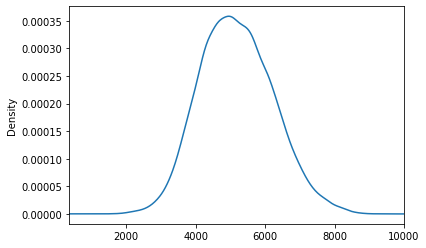

In [63]:
pd.DataFrame(data)['height'].plot(kind='kde', xlim=(360, 10000))

In [55]:
min(heights), max(heights)

(360, 9266)

In [53]:
[_ for _ in data if _['height'] == 360]

[{'fn': '../data/intermediary/google_search/iPhone-X/2020/01/01/Lance-Palmer/png/abstract_painting.png',
  'pixels_fullpage': {(255, 255, 255): 108992, (251, 188, 5): 20608},
  'pixels_firstglance': {(255, 255, 255): 108992,
   (0, 0, 0): 174900,
   (251, 188, 5): 20608},
  'height': 360}]

In [54]:
for fn in [_ for _ in data if _['height'] == 360]:
    os.remove(fn['fn'])

In [58]:
2

2

In [66]:
header = 160
footer = 230

In [67]:
avg - header - footer

4792.074549623321

In [69]:
4800 / 4

1200.0